# Exporting cloud-optimised GeoTIFF files <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background

At the end of an analysis it can be useful to export data to a GeoTIFF file (e.g. `outputname.tif`), either to save results or to allow for exploring results in a GIS software platform (e.g. ArcGIS or QGIS).

A `Cloud Optimized GeoTIFF` (COG) is a regular GeoTIFF file, aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud.

## Description

This notebook shows a number of ways to export a GeoTIFF file:

1. Exporting a single-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
2. Exporting a multi-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
3. Exporting multiple GeoTIFFs, one for each time-slice of an xarray object loaded through a `dc.load` query

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [5]:
%matplotlib inline

import datacube
from datacube.utils.cog import write_cog
import numpy as np
import xarray as xr
import sys

sys.path.append('../Scripts')
import dea_datahandling
from dea_plotting import rgb


### Connect to the datacube

In [6]:
dc = datacube.Datacube(app='Exporting_GeoTIFFs')


## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [7]:
# Create a query object
query = {
    'x': (153.40, 153.45),
    'y': (-28.85, -28.90),
    'time': ('2018-01', '2018-03'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from the Landsat 8
ds = dc.load(product='ga_ls8c_ard_3', **query)

# Print output data
print(ds)


<xarray.Dataset>
Dimensions:      (time: 6, x: 191, y: 212)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-03...
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 411 422 404 396 509 ... 244 285 307 251 247
    nbart_green  (time, y, x) int16 625 640 595 580 697 ... 343 407 470 372 371
    nbart_blue   (time, y, x) int16 435 430 421 412 542 ... 273 308 320 274 270
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Plot an rgb image to confirm we have data

The white regions are cloud cover.

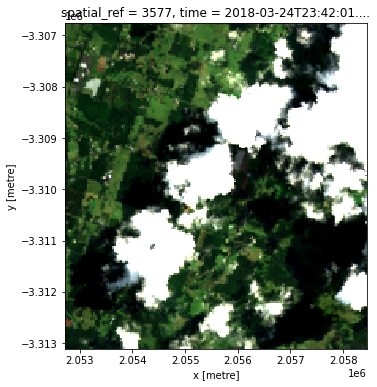

In [8]:
rgb(ds, index=5, percentile_stretch=(0.1, 0.8))


### Export a single-band, single time-slice GeoTIFF

This method uses the `datacube.utils.cog` function `write_cog` (where COG stands for [Cloud-Optimised-Geotiff](https://www.cogeo.org/)) to export a simple single-band, single time-slice GeoTIFF file.
A few important caveats should be noted when using this function:

1. It requires an `xarray.DataArray`; supplying an `xarray.Dataset` will return an error. To convert a `xarray.Dataset` to an `xarray.DataArray` run the following:

```
da = ds.to_array()
```

2. This function generates a temporary in-memory GeoTIFF file without compression. This means the function will temporarily use about 1.5 to 2 times the memory required using the deprecated `datacube.helper.write_geotiff`.

3. If you pass a `dask` array into the function, `write_cog` will not output a GeoTIFF, but will instead return a `dask.delayed` object. 
To trigger the output of the GeoTIFF run `.compute()` on the `dask.delayed` object:

```
write_cog(ds.red.isel(time=0), "red.tif").compute()
```

In [10]:
# Select a single time-slice and a single band from the dataset.
singleband_geotiff = ds.nbart_red.isel(time=1)

# Write GeoTIFF to a location
write_cog(singleband_geotiff,
          fname="red_band.tif",
          overwrite=True)

PosixPath('red_band.tif')

### Export a multi-band, single time-slice GeoTIFF

Here we select a single time and export all the bands in the dataset using the `datacube.helpers.write_geotiff` function.

In [11]:
# Select a single time-slice
rgb_geotiff = ds.isel(time=1).to_array()

# Write multi-band GeoTIFF to a location
write_cog(rgb_geotiff,
          fname='rgb.tif',
          overwrite=True)

PosixPath('rgb.tif')

### Export multiple GeoTIFF, one for each time-slice of an xarray

If we want to export all of the time steps in a dataset as a GeoTIFF, we can wrap our `write_geotiff` function in a for-loop.

In [12]:
for i in range(len(ds.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = str(ds.isel(time=i).time.data)[:-19]
    print(f'Writing {date}')
    
    # Convert current time step into a `xarray.DataArray`
    single_timestamp = ds.isel(time=i).to_array()

    # Write GeoTIFF  
    write_cog(single_timestamp,
              fname=f'{date}.tif',
              overwrite=True)

Writing 2018-01-03
Writing 2018-01-19
Writing 2018-02-04
Writing 2018-02-20
Writing 2018-03-08
Writing 2018-03-24


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)